In [1]:
import datasets
ds = datasets.load_dataset("cassanof/taco_cleaned_exec_filtered_v4_reasoning10", split="train")
ds

/home/elleven/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity', 'reasoning_steps'],
    num_rows: 7836
})

In [2]:
total_failed = 0
total_passed = 0
num_not_even_one = 0
for ex in ds:
    has_one = False
    for r in ex["reasoning_steps"]:
        if r is None:
            total_failed += 1
        else:
            has_one = True
            total_passed += 1
    num_not_even_one += int(not has_one)

print(f"Total reasoning agumentations that failed: {total_failed}")
print(f"Total reasoning agumentations that passed: {total_passed}")
print(f"Number of problems where there isn't even a single passing reasoning augmentation: {num_not_even_one}")

Total reasoning agumentations that failed: 3940
Total reasoning agumentations that passed: 56724
Number of problems where there isn't even a single passing reasoning augmentation: 78


In [3]:
from clean_reasoning_steps import get_reasoning_steps

code_example = """
# This is a leading comment
print(1 + 2) # This is a trailing comment
# This is considered
# the same comment
print(3 + 4)

def add(x, y):
    # A cool leading comment
    x = 3
    y = 3 # some leading comment
    z = 2
    return x + y +z
"""

print(get_reasoning_steps(code_example))

['This is a leading comment', 'This is considered the same comment', 'A cool leading comment']


In [4]:
import random
from tqdm import tqdm
random.seed(42)
sampled = []
groups = []
all_steps = []
most_steps = []
for ex in tqdm(ds, total=len(ds)):
    reasonings = [r for r in ex["reasoning_steps"] if r is not None]
    if len(reasonings) == 0:
        continue
    sampled.append(random.choice(reasonings))
    groups.append(reasonings)
    all_steps.extend(reasonings)
    max_steps = -1
    max_steps_sol = None
    for r in reasonings:
        steps = len(get_reasoning_steps(r))
        if steps > max_steps:
            max_steps_sol = r
            max_steps = steps

    most_steps.append(max_steps_sol)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7836/7836 [00:03<00:00, 2116.11it/s]


In [5]:
import re
from clean_reasoning_steps import transform_trailing_to_leading_comments



code_example = """
# This is a leading comment
print(1 + 2) # This is a trailing comment
x = 3 + 4 # Another trailing comment
y = x + 1

def add(x, y):
    # A cool leading comment
    x = 3
    y = 3 # some trailing comment
    z = 2
    return x + y + z
"""

transformed_code = transform_trailing_to_leading_comments(code_example)
print(transformed_code)


# This is a leading comment
# This is a trailing comment
print(1 + 2)
# Another trailing comment
x = 3 + 4
y = x + 1

def add(x, y):
    # A cool leading comment
    x = 3
    # some trailing comment
    y = 3
    z = 2
    return x + y + z



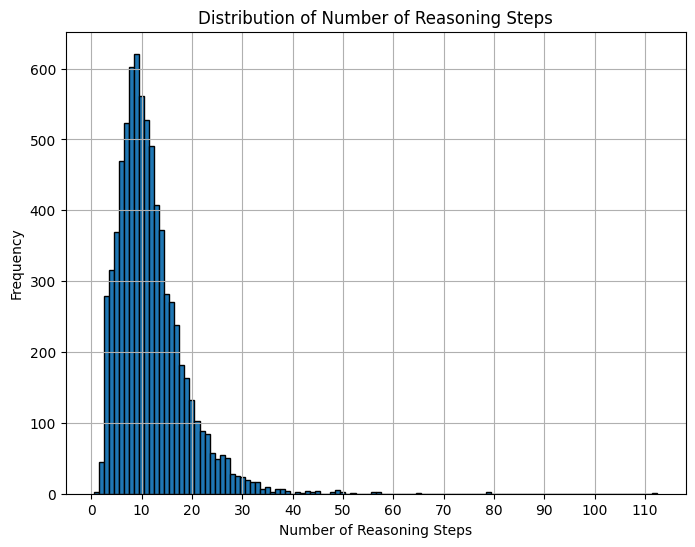

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# transform all first
sampled = [transform_trailing_to_leading_comments(s) for s in sampled]
reasoning_steps_counts = [len(get_reasoning_steps(code)) for code in sampled]


plt.figure(figsize=(8, 6))
plt.hist(reasoning_steps_counts, bins=np.arange(1, max(reasoning_steps_counts) + 2) - 0.5, edgecolor='black')
plt.xlabel('Number of Reasoning Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Reasoning Steps')
plt.xticks(np.arange(0, max(reasoning_steps_counts) + 1, step=10))
plt.grid(True)
plt.show()

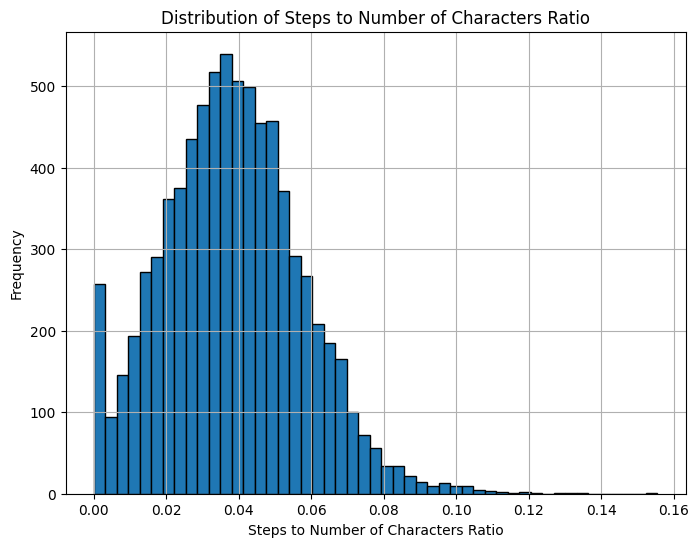

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from clean_reasoning_steps import get_steps_to_char_ratio


def remove_comments(code):
    """Remove comments from the code."""
    return "\n".join(line for line in code.split('\n') if not line.strip().startswith('#'))

def count_characters(code):
    """Count the number of characters without comments."""
    code_no_comments = remove_comments(code)
    return len(code_no_comments.replace('\n', '').replace(' ', ''))

steps_to_chars_ratios = [get_steps_to_char_ratio(code) for code in sampled]

plt.figure(figsize=(8, 6))
plt.hist(steps_to_chars_ratios, bins=np.linspace(0, max(steps_to_chars_ratios), 50), edgecolor='black')
plt.xlabel('Steps to Number of Characters Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Steps to Number of Characters Ratio')
plt.grid(True)
plt.show()

In [74]:
import ast
from tqdm import tqdm

def does_parse(code):
    try:
        ast.parse(code)
        return True
    except:
        return False

originals = []
transforms = []
for s in tqdm(sampled):
    assert does_parse(s)
    cleaned = transform_trailing_to_leading_comments(s)
    if cleaned != s:
        originals.append(s)
        transforms.append(cleaned)
    if not does_parse(cleaned):
        print(cleaned)
        break

len(transforms)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7758/7758 [00:03<00:00, 2281.71it/s]


304

In [79]:
import difflib
i =  3
print(originals[i])
print("====" * 40)
# print(transforms[i])
diff = difflib.unified_diff(originals[i].splitlines(), transforms[i].splitlines(), lineterm='')
print("\n".join(list(diff)))


import sys
sys.setrecursionlimit(10 ** 5 + 1)  # Set the recursion limit to handle large inputs

inf = int(10 ** 20)  # Define a large integer value for infinity
max_val = inf  # Initialize the maximum value to infinity
min_val = -inf  # Initialize the minimum value to negative infinity

RW = lambda : sys.stdin.readline().strip()  # Define a function to read a line of input
RI = lambda : int(RW())  # Define a function to read an integer from input
RMI = lambda : [int(x) for x in sys.stdin.readline().strip().split()]  # Define a function to read multiple integers from input
RWI = lambda : [x for x in sys.stdin.readline().strip().split()]  # Define a function to read multiple words from input

nb_mines = RI()  # Read the number of mines from input

(x_coord, y_coord) = ([], [])  # Initialize empty lists to store x and y coordinates of mines

# Read the coordinates of each mine and store them in the respective lists
for _ in range(nb_mines):
	(x, y) = RMI()
	x_coord.append(x)
	y_coord.ap

In [13]:
singles = []
large = []
for s in sampled:
    steps = len(get_reasoning_steps(s))
    if steps == 1:
        singles.append(s)
    elif steps >= 50:
        large.append(s)

In [22]:
print(len(large))

13
